In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Financials 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data.drop(columns=['purchasing power of the consumer dollar','other personal services'],axis=1,inplace=True)
data = data.dropna()
data

,date,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),S&P 500 Financials (Sector) Outperform/Underperform,overall,commodities,other services,housing,shelter,services
0,1993-05-04,444.05,99.760002,-6.025142,-11.607300,-11.607300092084882,144.300,131.300,176.600,141.200,155.800,157.8
1,1993-05-05,444.52,99.500000,-5.979399,-11.610553,UNDERPERFORM,144.300,131.300,176.600,141.200,155.800,157.8
2,1993-05-06,443.26,99.190002,-5.757537,-11.823270,UNDERPERFORM,144.300,131.300,176.600,141.200,155.800,157.8
3,1993-05-07,442.31,99.129997,-5.426672,-11.514775,UNDERPERFORM,144.300,131.300,176.600,141.200,155.800,157.8
4,1993-05-10,442.80,99.660004,-6.078989,-11.742822,UNDERPERFORM,144.300,131.300,176.600,141.200,155.800,157.8
...,...,...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,1656.619995,19.548197,33.691106,OUTPERFORM,280.126,210.452,380.688,288.259,341.963,348.1
7195,2021-11-26,4594.62,1612.869995,16.437110,28.495065,OUTPERFORM,280.126,210.452,380.688,288.259,341.963,348.1
7196,2021-11-29,4655.27,1639.089966,19.324593,31.459531,OUTPERFORM,280.126,210.452,380.688,288.259,341.963,348.1
7197,2021-11-30,4567.00,1615.829956,17.908879,30.688282,OUTPERFORM,280.126,210.452,380.688,288.259,341.963,348.1


## Using all data

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),S&P 500 Financials (Sector) Outperform/Underperform,overall,commodities,other services,housing,shelter,services,dow
0,1993,5,1993-05-13,439.23,99.300003,-5.758792,-11.701935,UNDERPERFORM,144.300,131.300,176.600,141.200,155.800,157.800,3
1,1993,6,1993-06-10,445.38,100.440002,-4.085280,-10.910055,UNDERPERFORM,144.500,131.300,177.100,141.300,155.900,158.100,3
2,1993,7,1993-07-08,448.64,99.639999,-0.020057,-4.513655,UNDERPERFORM,144.800,131.600,177.800,141.700,156.200,158.600,3
3,1993,8,1993-08-12,448.96,102.529999,-1.830188,-3.355639,UNDERPERFORM,145.000,131.300,178.900,142.000,156.500,159.000,3
4,1993,9,1993-09-09,457.50,102.480003,3.319783,0.569186,UNDERPERFORM,145.600,132.200,179.700,142.300,156.900,159.400,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,1462.900024,1.147999,5.918213,OUTPERFORM,273.092,201.975,377.425,281.979,335.888,342.831,3
339,2021,8,2021-08-12,4460.83,1448.939941,7.276877,20.694706,OUTPERFORM,274.214,203.215,378.584,283.532,337.298,343.808,3
340,2021,9,2021-09-09,4493.28,1470.270020,15.209058,28.911119,OUTPERFORM,276.590,206.035,380.322,285.453,338.865,345.648,3
341,2021,10,2021-10-14,4438.26,1476.890015,8.483351,15.471341,OUTPERFORM,278.524,208.467,380.061,286.849,340.475,346.911,3


In [4]:
original = data[['S&P 500 Financials (Sector) Outperform/Underperform','month','overall','commodities',\
                 'other services','housing','shelter','services']]

In [5]:
data.drop(columns=['date','S&P 500 Financials (Sector) Outperform/Underperform','year'], inplace=True)
data.head()

,month,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),overall,commodities,other services,housing,shelter,services,dow
0,5,439.23,99.300003,-5.758792,-11.701935,144.3,131.3,176.6,141.2,155.8,157.8,3
1,6,445.38,100.440002,-4.085280,-10.910055,144.5,131.3,177.1,141.3,155.9,158.1,3
2,7,448.64,99.639999,-0.020057,-4.513655,144.8,131.6,177.8,141.7,156.2,158.6,3
3,8,448.96,102.529999,-1.830188,-3.355639,145.0,131.3,178.9,142.0,156.5,159.0,3
4,9,457.50,102.480003,3.319783,0.569186,145.6,132.2,179.7,142.3,156.9,159.4,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Financials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities',\
                 'other services','housing','shelter','services']]

In [7]:
dd.data_summary(original)

,Info
Rows,343
Columns,8
Size in Memory,21.6 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.43,0.50,2,195
month,int64,0,0,1,7,12,6.53,3.44,12,29
overall,float64,0,0,144.30,208.55,280.13,205.34,36.44,328,3
commodities,float64,0,0,131.30,167.20,210.45,165.28,19.54,291,4
other services,float64,0,0,176.60,287.23,380.69,283.13,58.59,341,2
housing,float64,0,0,141.20,210.50,288.26,205.75,39.72,337,2
shelter,float64,0,0,155.80,242.037,341.96,238.0078,50.65,336,2
services,float64,0,0,157.80,248.25,348.10,245.092,53.60,343,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

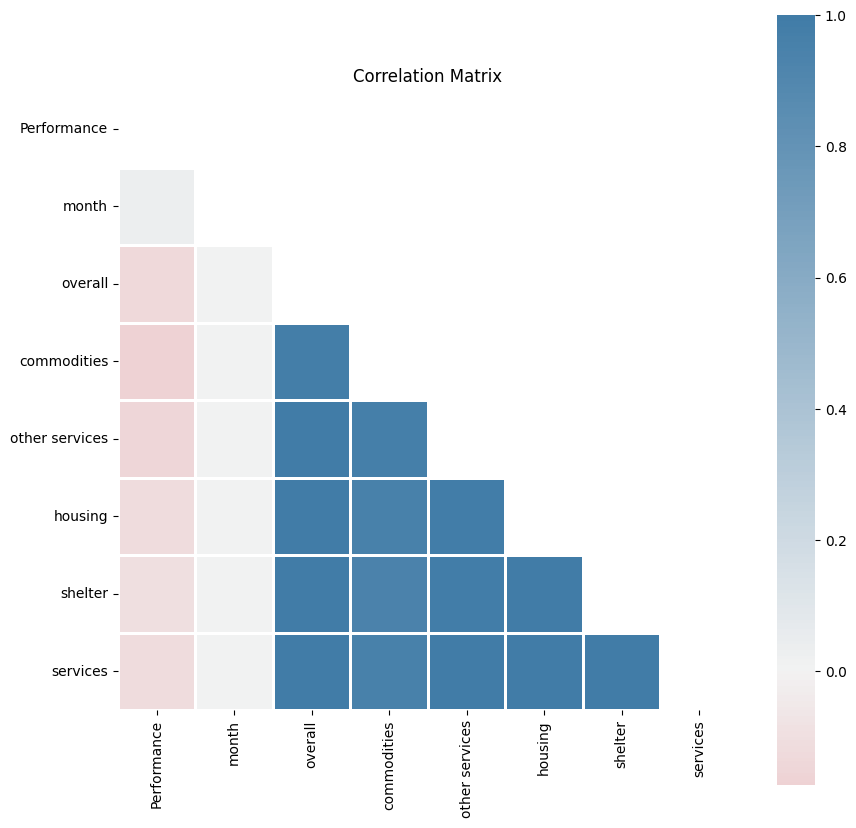

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),overall,commodities,other services,housing,shelter,services,dow
0,10,2317.429711,222.207423,-22.062318,-24.034075,226.247244,180.334584,324.977366,223.254917,274.839515,274.040142,3
1,7,1172.419108,241.531042,-3.372468,11.988102,166.779584,143.429537,243.179202,172.376796,186.000766,185.429955,3
2,11,2203.738496,768.861773,-1.147367,2.274379,265.295727,184.565485,340.290696,267.922951,307.045359,317.387816,3
3,6,1104.543292,300.302362,43.827711,2.920413,171.619094,147.274516,257.210743,166.141704,242.422675,185.716945,3
4,3,3024.045726,215.478487,-12.587159,-21.671714,208.012354,178.300363,325.531337,218.473728,247.593903,241.905262,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11,3233.135950,702.088307,-13.004589,-3.700729,280.983706,178.256716,364.504564,267.840866,298.014188,293.570698,3
9996,11,1353.318401,368.462606,16.719957,-3.920210,176.715624,152.634449,253.656470,187.835022,255.413141,211.665368,3
9997,9,1363.387735,285.943900,9.506093,44.849018,244.563030,152.618026,264.327361,221.442025,251.605746,256.580784,3
9998,6,1319.110459,237.878150,-20.764602,-21.185286,165.935767,144.339038,235.207192,162.927695,178.899779,206.488127,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Financials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month', 'overall','commodities',\
                 'other services','housing','shelter','services']]
samples.head()

,Performance,month,overall,commodities,other services,housing,shelter,services
0,0,10,226.247244,180.334584,324.977366,223.254917,274.839515,274.040142
1,1,7,166.779584,143.429537,243.179202,172.376796,186.000766,185.429955
2,1,11,265.295727,184.565485,340.290696,267.922951,307.045359,317.387816
3,0,6,171.619094,147.274516,257.210743,166.141704,242.422675,185.716945
4,0,3,208.012354,178.300363,325.531337,218.473728,247.593903,241.905262


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,8
Size in Memory,625.1 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.35,0.48,2,6450
month,int64,0,0,1,7,12,6.51,3.46,12,906
overall,float64,0,0,128.22,216.55,307.28,208.77,38.056,10000,1
commodities,float64,0,0,125.47,167.65,206.74,164.32,19.30,10000,1
other services,float64,0,0,138.27,279.80,418.18,275.21,58.68,10000,1
housing,float64,0,0,129.17,212.79,313.11,209.41,37.81,10000,1
shelter,float64,0,0,145.62,239.049,361.68,235.60,48.84,9998,2
services,float64,0,0,146.19,254.61,366.26,248.24,51.63,9998,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

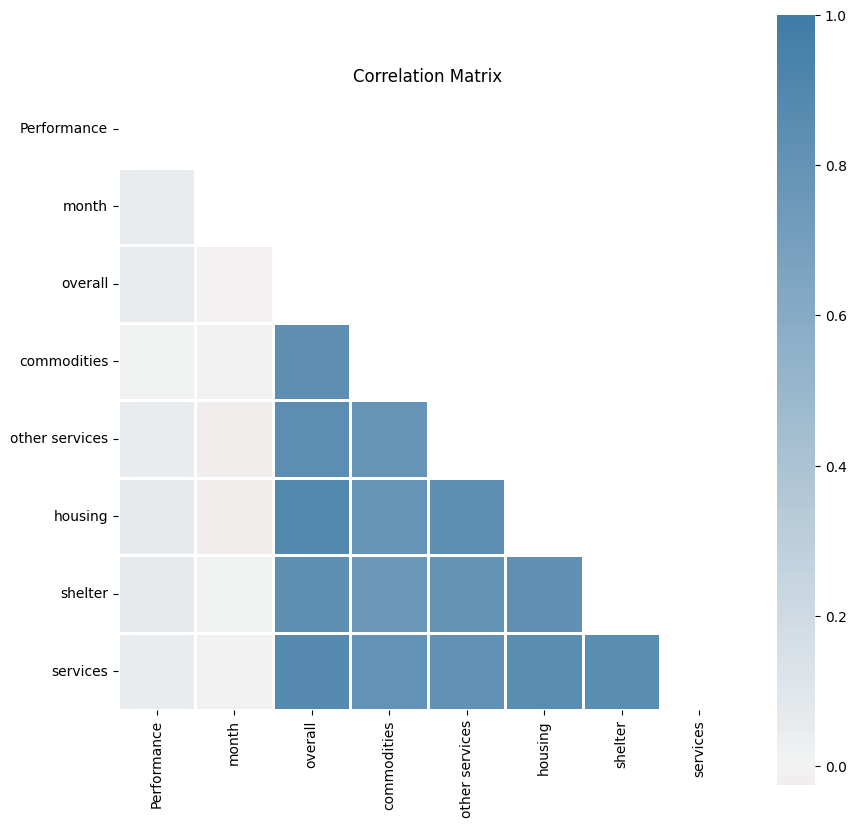

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({0: 6450, 1: 3550})
Counter({0: 6450, 1: 6450})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  226.24724418,   180.3345838 ,   324.97736582, ...,
        61359.2730351 , 61180.80901303, 75317.05972254],
       [  166.77958363,   143.42953652,   243.17920182, ...,
        32062.21595351, 31963.82143003, 34490.11357748],
       [  265.29572743,   184.56548471,   340.29069629, ...,
        82264.49867846, 85035.48026645, 97452.45608461],
       ...,
       [  271.75186214,   189.54918354,   329.58040803, ...,
        87290.04693537, 89725.53234862, 99625.71034392],
       [  217.72308074,   182.91679137,   293.44112936, ...,
        47821.19822325, 62526.24504233, 67779.85703136],
       [  164.06062072,   140.70633008,   215.25177652, ...,
        31151.12948291, 30590.04102543, 30238.08054298]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(12900, 22)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(343, 22)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.631085,0.611867,0.710543,0.656723,0.608992,0.59516,0.673304,0.631825,0.548105,0.477707,0.506757,0.491803
1,DecisionTreeClassifier,0.633333,0.621693,0.672403,0.645124,0.612093,0.600793,0.660236,0.629114,0.469388,0.376812,0.351351,0.363636
2,RandomForestClassifier,0.73845,0.727344,0.753333,0.736205,0.707597,0.703931,0.71313,0.708501,0.536443,0.447619,0.317568,0.371542
3,AdaBoostClassifier,0.568062,0.579347,0.500465,0.536637,0.571163,0.582474,0.492222,0.533558,0.571429,0.504202,0.405405,0.449438
4,GradientBoostingClassifier,0.582326,0.594452,0.517054,0.552667,0.590388,0.600846,0.53018,0.563306,0.530612,0.448819,0.385135,0.414545
5,ExtraTreesClassifier,0.769922,0.763523,0.774109,0.764405,0.723101,0.724528,0.716864,0.720676,0.51895,0.410526,0.263514,0.320988
6,BaggingClassifier,0.685969,0.696539,0.648372,0.668518,0.651473,0.67019,0.591786,0.628553,0.498542,0.377551,0.25,0.300813
7,SVC,0.560775,0.571047,0.491473,0.527935,0.557829,0.561691,0.512757,0.536109,0.516035,0.43662,0.418919,0.427586
8,GaussianNB,0.537054,0.554959,0.376434,0.448441,0.534884,0.54624,0.393279,0.457308,0.507289,0.411765,0.331081,0.367041


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.704806,0.699573,0.714375,0.706897


## Using data after 2000

In [22]:
data = pd.read_csv('../data/S&P 500 Financials 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data.drop(columns=['purchasing power of the consumer dollar','other personal services'],axis=1,inplace=True)
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),S&P 500 Financials (Sector) Outperform/Underperform,overall,commodities,other services,housing,shelter,services,dow
80,2000,1,2000-01-13,1449.68,298.109985,5.081257,29.119014,OUTPERFORM,170.000,147.600,227.200,167.300,190.900,192.500,3
81,2000,2,2000-02-10,1416.83,280.170013,5.594103,24.354199,OUTPERFORM,171.000,149.100,227.700,167.700,191.600,193.100,3
82,2000,3,2000-03-09,1401.69,255.740005,9.948543,12.334183,OUTPERFORM,170.900,148.500,228.100,167.900,191.900,193.500,3
83,2000,4,2000-04-13,1440.51,286.480011,4.861217,7.590049,OUTPERFORM,171.200,148.500,228.700,168.300,192.400,194.000,3
84,2000,5,2000-05-11,1407.81,272.510010,11.913923,7.830804,UNDERPERFORM,172.200,149.600,229.200,169.200,193.100,194.900,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,1462.900024,1.147999,5.918213,OUTPERFORM,273.092,201.975,377.425,281.979,335.888,342.831,3
339,2021,8,2021-08-12,4460.83,1448.939941,7.276877,20.694706,OUTPERFORM,274.214,203.215,378.584,283.532,337.298,343.808,3
340,2021,9,2021-09-09,4493.28,1470.270020,15.209058,28.911119,OUTPERFORM,276.590,206.035,380.322,285.453,338.865,345.648,3
341,2021,10,2021-10-14,4438.26,1476.890015,8.483351,15.471341,OUTPERFORM,278.524,208.467,380.061,286.849,340.475,346.911,3


In [23]:
original = data[['S&P 500 Financials (Sector) Outperform/Underperform','month','overall','commodities',\
                 'other services','housing','shelter','services']]
data.drop(columns=['date','S&P 500 Financials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Financials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities',\
                 'other services','housing','shelter','services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),overall,commodities,other services,housing,shelter,services,dow
0,11,1126.180396,292.102226,-10.180860,-22.192520,248.154902,187.941117,330.527171,233.441553,265.080328,285.085575,3
1,4,1308.899299,285.849523,-1.690996,-19.132529,226.317880,152.242304,270.225607,183.040041,204.798517,222.197913,3
2,10,3047.862939,1121.061908,-23.105011,-17.874231,253.144834,190.902206,349.129523,283.587464,338.944186,346.074918,3
3,2,1059.661327,247.936485,0.563225,-4.051363,179.593601,151.164321,260.837146,184.554019,217.816693,218.739867,3
4,6,1507.636943,333.497702,37.573888,54.127874,232.656429,150.128742,270.929710,210.123230,200.895668,237.192713,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8,1955.283562,606.735934,-13.590700,-25.591608,245.325636,183.713573,319.099630,266.028330,311.119051,305.541838,3
9996,2,1089.749886,200.745086,-13.934085,-14.470268,229.265145,167.452414,247.843633,189.558236,210.871536,269.117786,3
9997,3,3814.847554,873.147409,-6.351498,-3.686289,267.441185,183.021319,374.819668,283.432471,314.288827,324.628647,3
9998,10,1121.987271,206.334110,-26.174241,-23.271030,182.297488,152.896770,273.646194,189.396810,224.263059,230.236495,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Financials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','commodities',\
                 'other services','housing','shelter','services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.585084,0.593395,0.551795,0.57109,0.594989,0.604858,0.556632,0.579744,0.619772,0.484848,0.494845,0.489796
1,DecisionTreeClassifier,0.561435,0.565555,0.557035,0.560038,0.540015,0.542683,0.530551,0.536549,0.505703,0.358974,0.43299,0.392523
2,RandomForestClassifier,0.619215,0.639411,0.576673,0.603363,0.596859,0.604928,0.567064,0.585385,0.619772,0.484211,0.474227,0.479167
3,AdaBoostClassifier,0.596016,0.607463,0.54394,0.573628,0.588631,0.602369,0.530551,0.564184,0.577947,0.439655,0.525773,0.478873
4,GradientBoostingClassifier,0.603405,0.614963,0.554791,0.583167,0.605086,0.617021,0.561848,0.588144,0.612167,0.47619,0.515464,0.49505
5,ExtraTreesClassifier,0.625198,0.644557,0.600231,0.616984,0.611444,0.620143,0.582712,0.600845,0.669202,0.554348,0.525773,0.539683
6,BaggingClassifier,0.592192,0.621797,0.488222,0.545084,0.574794,0.597156,0.469449,0.525657,0.60076,0.455556,0.42268,0.438503
7,SVC,0.587512,0.5871,0.589942,0.588466,0.586013,0.583392,0.612519,0.597601,0.612167,0.479339,0.597938,0.53211
8,GaussianNB,0.57919,0.582834,0.558154,0.570145,0.568437,0.570571,0.566319,0.568437,0.56654,0.414141,0.42268,0.418367


## Using data after 2010 (Best Model)

In [25]:
data = pd.read_csv('../data/S&P 500 Financials 200-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data.drop(columns=['purchasing power of the consumer dollar','other personal services'],axis=1,inplace=True)
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),S&P 500 Financials (Sector) Outperform/Underperform,overall,commodities,other services,housing,shelter,services,dow
200,2010,1,2010-01-14,1148.46,238.649994,-2.941027,-14.000002,UNDERPERFORM,217.281,174.321,307.253,216.042,247.997,259.970,3
201,2010,2,2010-02-11,1078.47,230.320007,-9.326551,-19.651138,UNDERPERFORM,217.353,174.137,307.568,216.146,247.914,260.342,3
202,2010,3,2010-03-11,1150.24,252.570007,-8.476491,-14.876474,UNDERPERFORM,217.403,173.874,308.675,216.092,247.959,260.672,3
203,2010,4,2010-04-08,1186.44,265.380005,-7.551331,-11.223360,UNDERPERFORM,217.290,173.367,309.303,216.128,248.128,260.932,3
204,2010,5,2010-05-13,1157.44,264.690002,-12.792152,-14.717915,UNDERPERFORM,217.199,172.929,309.997,216.060,248.295,261.188,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,1462.900024,1.147999,5.918213,OUTPERFORM,273.092,201.975,377.425,281.979,335.888,342.831,3
339,2021,8,2021-08-12,4460.83,1448.939941,7.276877,20.694706,OUTPERFORM,274.214,203.215,378.584,283.532,337.298,343.808,3
340,2021,9,2021-09-09,4493.28,1470.270020,15.209058,28.911119,OUTPERFORM,276.590,206.035,380.322,285.453,338.865,345.648,3
341,2021,10,2021-10-14,4438.26,1476.890015,8.483351,15.471341,OUTPERFORM,278.524,208.467,380.061,286.849,340.475,346.911,3


In [26]:
original = data[['S&P 500 Financials (Sector) Outperform/Underperform','month','overall','commodities',\
                 'other services','housing','shelter','services']]
data.drop(columns=['date','S&P 500 Financials (Sector) Outperform/Underperform','year'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Financials (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','commodities',\
                 'other services','housing','shelter','services']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,month,S&P 500,S&P 500 Financials (Sector),S&P 500 Performance (%),S&P 500 Financials (Sector) Performance (%),overall,commodities,other services,housing,shelter,services,dow
0,4,1116.459632,322.819592,7.424867,-9.159492,231.464425,186.673346,309.316561,220.233844,247.674677,267.759490,3
1,9,3317.491807,967.327915,-8.514710,-5.374020,258.992320,185.950656,359.768023,269.081617,318.816902,326.991566,3
2,2,1583.124997,614.445284,-16.504325,-26.379990,243.820613,186.495890,349.973071,222.764963,259.077532,264.711759,3
3,9,2692.627500,681.480223,-11.266367,-12.987794,257.824910,181.034606,347.166145,267.544426,304.594513,328.125998,3
4,5,2362.047759,587.536408,-1.414909,-7.752755,261.257910,177.649494,347.234016,249.918074,266.417750,287.841055,3
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4,2365.386079,733.524507,-3.412195,-9.816725,250.956702,180.383606,354.713606,246.723605,307.489394,316.363884,3
9996,3,2926.826468,898.551141,2.773616,-4.224302,268.513259,205.217532,365.586974,292.307885,327.071711,313.712577,3
9997,4,1260.750826,196.353174,11.406691,-4.584304,219.643795,180.668694,306.556962,221.613643,261.661332,263.464077,3
9998,6,1261.990461,392.699021,-6.897684,-13.204630,232.510902,171.363283,339.885680,229.873391,289.929366,295.288338,3


In [27]:
samples['Performance'] = np.where(samples['S&P 500 Financials (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month', 'overall','commodities',\
                 'other services','housing','shelter','services']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.735652,0.693835,0.84253,0.760291,0.712669,0.674451,0.807606,0.735047,0.706294,0.563636,0.632653,0.596154
1,DecisionTreeClassifier,0.72054,0.705513,0.755859,0.728958,0.701352,0.684623,0.732103,0.707568,0.608392,0.433962,0.469388,0.45098
2,RandomForestClassifier,0.825564,0.810993,0.848323,0.827851,0.796577,0.785443,0.808725,0.796914,0.671329,0.527778,0.387755,0.447059
3,AdaBoostClassifier,0.665197,0.669086,0.654016,0.661204,0.659398,0.655968,0.651566,0.65376,0.629371,0.467742,0.591837,0.522523
4,GradientBoostingClassifier,0.679343,0.677631,0.683689,0.680483,0.674579,0.669827,0.6717,0.670762,0.629371,0.469697,0.632653,0.53913
5,ExtraTreesClassifier,0.862067,0.844772,0.886826,0.864225,0.828319,0.816848,0.840604,0.828556,0.699301,0.6,0.367347,0.455696
6,BaggingClassifier,0.786852,0.793556,0.775179,0.782635,0.746619,0.748288,0.733221,0.740678,0.636364,0.457143,0.326531,0.380952
7,SVC,0.646772,0.661236,0.601986,0.630114,0.638421,0.648447,0.583893,0.614479,0.664336,0.509434,0.55102,0.529412
8,GaussianNB,0.634833,0.658587,0.560312,0.605348,0.629037,0.645861,0.549776,0.593958,0.685315,0.541667,0.530612,0.536082
